![spreedsheet_finance](spreedsheet_finance.jpg)

Your project is centered around developing a reinforcement learning (RL) simulation for stock trading in Python. This initiative is spearheaded by Quantum Trading, a fictional but ambitious trading firm looking to leverage cutting-edge machine learning techniques to gain a competitive edge in the financial markets. Quantum Trading is a small but highly specialised team of financial analysts, data scientists, and software engineers who are passionate about transforming the way trading decisions are made.

In the fast-paced world of financial markets, staying ahead of the curve is crucial. Traditional trading strategies, while effective, often rely on historical data and predefined rules that may not adapt quickly to changing market conditions. Reinforcement learning, a subfield of machine learning where an agent learns to make decisions by interacting with an environment, offers a promising alternative. It allows the trading algorithms to learn and adapt in real-time, improving their performance as they gain more experience.

By engaging with this project, you will gain valuable insights into the dynamic world of algorithmic trading and enhance your skill set in data science, finance, and machine learning. Remember, the journey of learning and experimentation is as important as the results. Good luck, and may your trading algorithms be ever profitable!

## The Data
The provided data `AAPL.csv` contains historical prices for AAPL (the ticker symbol for Apple Inc) and you will be using this in your model. It has been loaded for you already in the sample code below and contains two columns, described below.

| Column | Description |
|--------|-------------|
|`Date`    | The date corresponding to the closing price              |
|`Close`   | The closing price of the security on the given date      |

_**Disclaimer: This project is for educational purposes only. It is not financial advice, and should not be understood or construed as, financial advice.**_

In [1]:
# Make sure to run this cell to use gymnasium gym-anytrading stable-baselines3
!pip install gymnasium gym-anytrading stable-baselines3

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 69.3 MB/s eta 0:00:00


In [2]:
# Import required packages
# Note that gym-anytrading is a gym environment specific for trading
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gymnasium as gym
import gym_anytrading
from gym_anytrading.envs import Actions
from stable_baselines3 import PPO

# Load the data provided
data = pd.read_csv("AAPL.csv", parse_dates=True, index_col='Date')

# Set window size (lookback window), start and end index of data
window_size = 10
start_index = window_size
end_index = len(data)

# Create the environment using the pre-built 'stocks-v0', passing in the data loaded above
# window_size is how far the environment can look back at each step
# frame_bound is the bounding box of the environment, the size of our data
env = gym.make('stocks-v0', df=data, window_size=window_size, frame_bound=(start_index, end_index))
print("Observation Space:", env.observation_space)

# Initialise cash balance tracking and other variables
balance = 100000
balance_history = [balance]
shares_held = 0
action_stats = {Actions.Sell: 0, Actions.Buy: 0}
observation, info = env.reset(seed=2024)

Observation Space: Box(-10000000000.0, 10000000000.0, (10, 2), float32)


Observation Space: Box(-10000000000.0, 10000000000.0, (10, 2), float32)
0: BUY  134.43 shares at $74.39 | Balance: $90000.00
1: BUY  119.75 shares at $75.16 | Balance: $81000.00
2: BUY  106.67 shares at $75.93 | Balance: $72900.00
3: BUY  94.03 shares at $77.53 | Balance: $65610.00
4: SELL 454.87 shares at $78.75 | Balance: $101432.19
5: HOLD | Current price: $77.85 | Balance: $101432.19
6: BUY  131.88 shares at $76.91 | Balance: $91288.97
7: SELL 131.88 shares at $77.39 | Balance: $101494.50
8: BUY  131.94 shares at $76.93 | Balance: $91345.05
9: BUY  116.01 shares at $78.74 | Balance: $82210.55
10: SELL 247.94 shares at $78.29 | Balance: $101620.82
11: BUY  127.33 shares at $79.81 | Balance: $91458.74
12: SELL 127.33 shares at $79.21 | Balance: $101545.06
13: HOLD | Current price: $79.72 | Balance: $101545.06
14: BUY  128.24 shares at $79.18 | Balance: $91390.55
15: SELL 128.24 shares at $79.53 | Balance: $101589.30
16: HOLD | Current price: $79.56 | Balance: $101589.30
17: HOLD | Cu

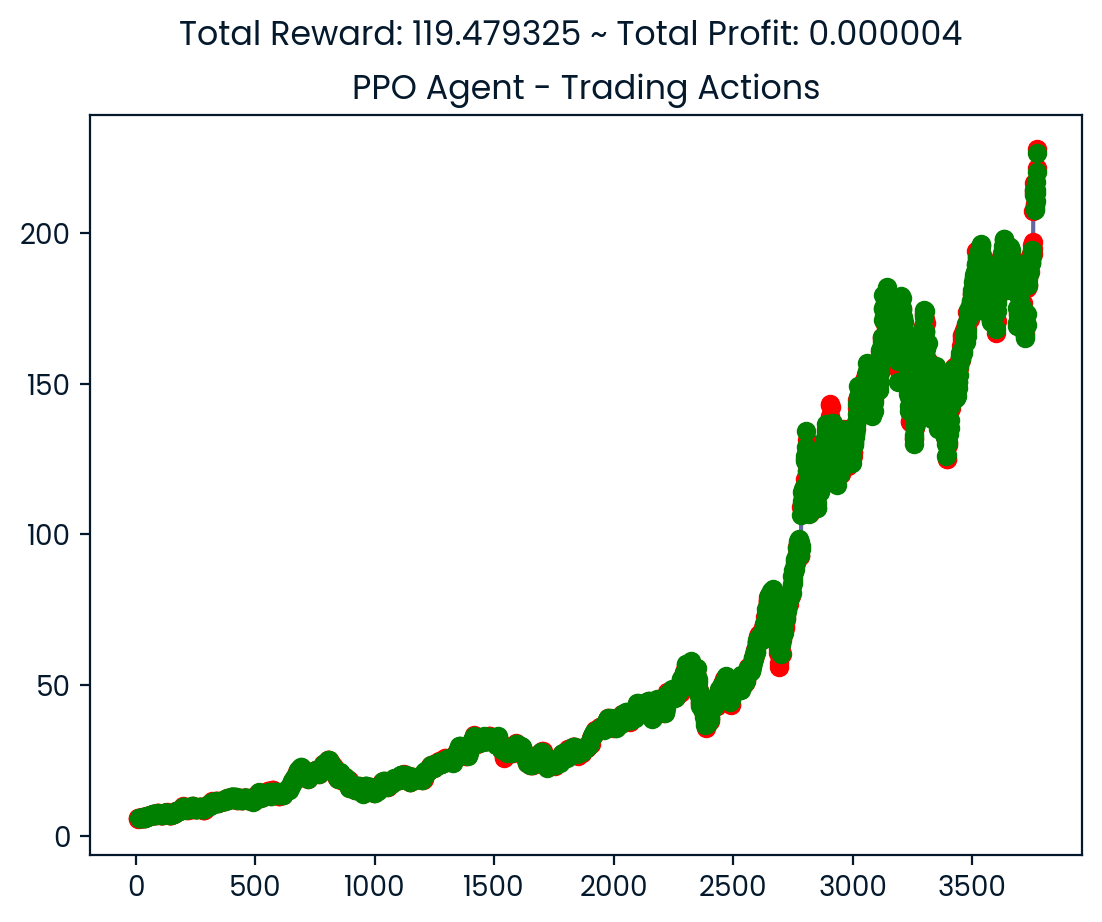

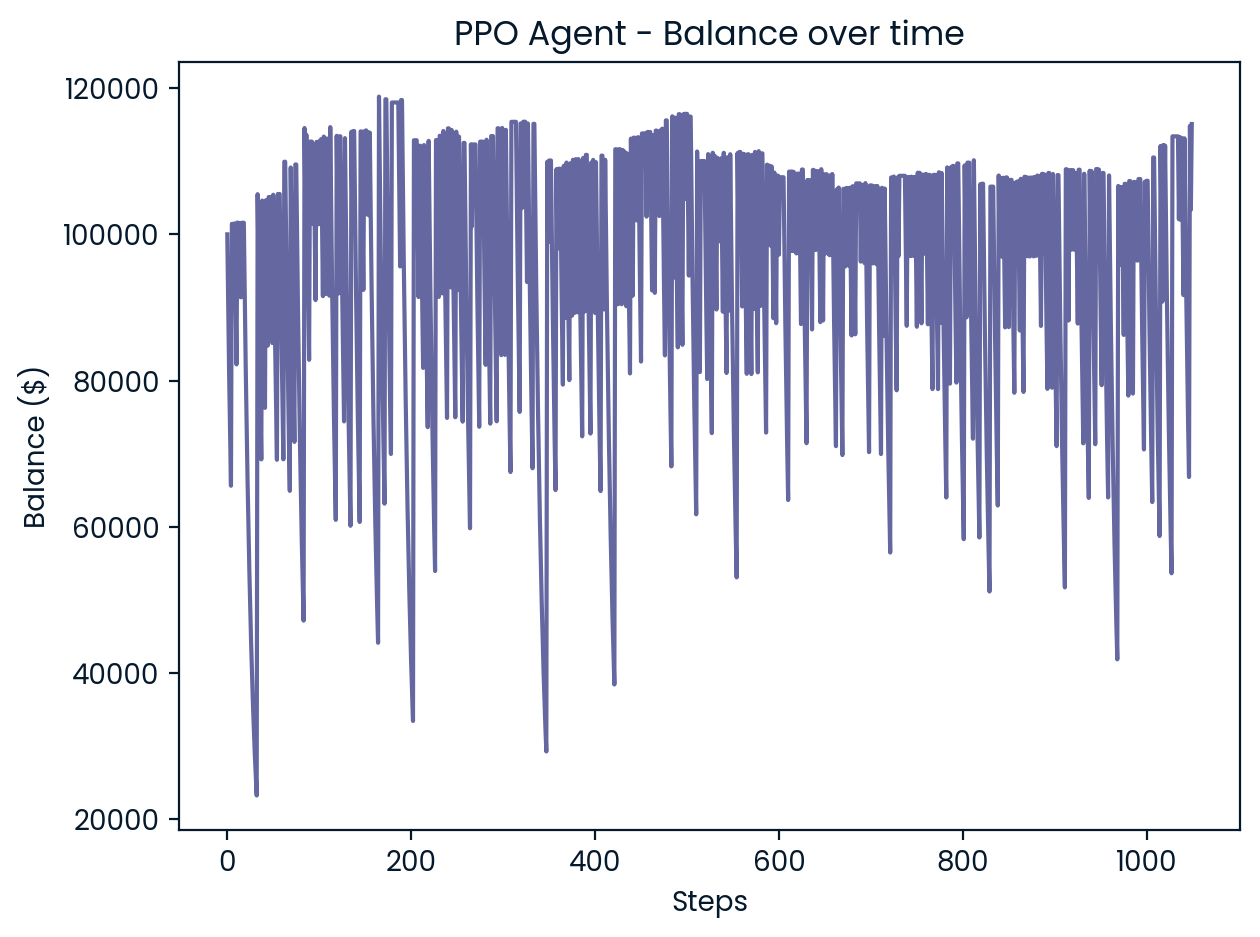

'\nQuestions/Answers\n- What do you think about the performance of this model?\nThe model has technically been profitable in that the cash balance is higher than what it started with. However, it is very hard to not be profitable given the extreme increase in the price of AAPL over the 15 years of data provided. You would have made significantly more by simply spending all of the initial balance on shares at the starting date, holding the shares, and selling at the ending date. You likely would have made significantly more over that time period by investing your initial balance in any number of asset classes.\n- Why do you think it has performed the way it has?\nEvery transaction that this model makes is the same size. That is why your balance history will have a lot of spikes and drops, as the model buys with 10% of its balance and then sells again instantly with 10% of its balance, making either a small profit or loss. An improvement that could be made here is calculating the positio

In [3]:
# Start coding here by training the PPO model
# Import required packages
# Note that gym-anytrading is a gym environment specific for trading
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gymnasium as gym
import gym_anytrading
from gym_anytrading.envs import Actions
from stable_baselines3 import PPO

# Load the data provided
data = pd.read_csv("AAPL.csv", parse_dates=True, index_col='Date')

# Set window size (lookback window), start and end index of data
window_size = 10
start_index = window_size
end_index = len(data)

# Create the environment using the pre-built 'stocks-v0', passing in the data loaded above
# window_size is how far the environment can look back at each step
# frame_bound is the bounding box of the environment, the size of our data
env = gym.make('stocks-v0', df=data, window_size=window_size, frame_bound=(start_index, end_index))
print("Observation Space:", env.observation_space)

# Initialise cash balance tracking and other variables
balance = 100000
balance_history = [balance]
shares_held = 0
action_stats = {Actions.Sell: 0, Actions.Buy: 0}
observation, info = env.reset(seed=2024)

# Train the PPO model
model = PPO('MlpPolicy', env, verbose=0)
model.learn(total_timesteps=10000)

step = 0
while True:
    action, _states = model.predict(observation)
    current_price = env.unwrapped.prices[env.unwrapped._current_tick]
    
    observation, reward, terminated, truncated, info = env.step(action)
    
    trade_amount = balance * 0.10  # Trade with 10% of current balance
    
    if action == Actions.Buy.value:
        shares_to_buy = trade_amount / current_price
        shares_held += shares_to_buy
        balance -= trade_amount
        print(f"{step}: BUY  {shares_to_buy:.2f} shares at ${current_price:.2f} | Balance: ${balance:.2f}")
    elif action == Actions.Sell.value and shares_held > 0:
        balance += shares_held * current_price
        print(f"{step}: SELL {shares_held:.2f} shares at ${current_price:.2f} | Balance: ${balance:.2f}")
        shares_held = 0
    else:
        print(f"{step}: HOLD | Current price: ${current_price:.2f} | Balance: ${balance:.2f}")
    
    action_stats[Actions(action)] += 1
    balance_history.append(balance)
    
    step += 1
    if terminated or truncated:
        break
		
# If we still hold shares at the end, sell them all
if shares_held > 0:
    balance += shares_held * current_price
    print(f"\nFinal SELL {shares_held:.2f} shares at ${current_price:.2f} | Balance: ${balance:.2f}")
    shares_held = 0

env.close()

print("Action stats:", action_stats)
print(f"Final Balance: ${balance:.2f}")

# Create a price chart showing buy/sell actions
fig, ax = plt.subplots()
env.unwrapped.render_all()
ax.set_title("PPO Agent - Trading Actions")
plt.show()

# Create a chart showing cash balance over time
fig2, ax2 = plt.subplots()
ax2.plot(balance_history)
ax2.set_title("PPO Agent - Balance over time")
ax2.set_xlabel("Steps")
ax2.set_ylabel("Balance ($)")

fig2.tight_layout()
plt.show()

"""
Questions/Answers
- What do you think about the performance of this model?
The model has technically been profitable in that the cash balance is higher than what it started with. However, it is very hard to not be profitable given the extreme increase in the price of AAPL over the 15 years of data provided. You would have made significantly more by simply spending all of the initial balance on shares at the starting date, holding the shares, and selling at the ending date. You likely would have made significantly more over that time period by investing your initial balance in any number of asset classes.
- Why do you think it has performed the way it has?
Every transaction that this model makes is the same size. That is why your balance history will have a lot of spikes and drops, as the model buys with 10% of its balance and then sells again instantly with 10% of its balance, making either a small profit or loss. An improvement that could be made here is calculating the position size based on the confidence the model has in its decision, taking a smaller position if less confident and a larger position if more confident. This model also does not account for any transaction costs or slippage which would be a key factor in a real trading scenario.
- How could the data we have selected impact the performance of the model?
This model uses 15 years of data which is a long time. It is very hard to not make money given a stock that has gone from around $4 to over $200! An interesting experiment would be to select some stock data for a company that has not seen the same extreme growth that Apple has seen and observe how the model performs.
"""

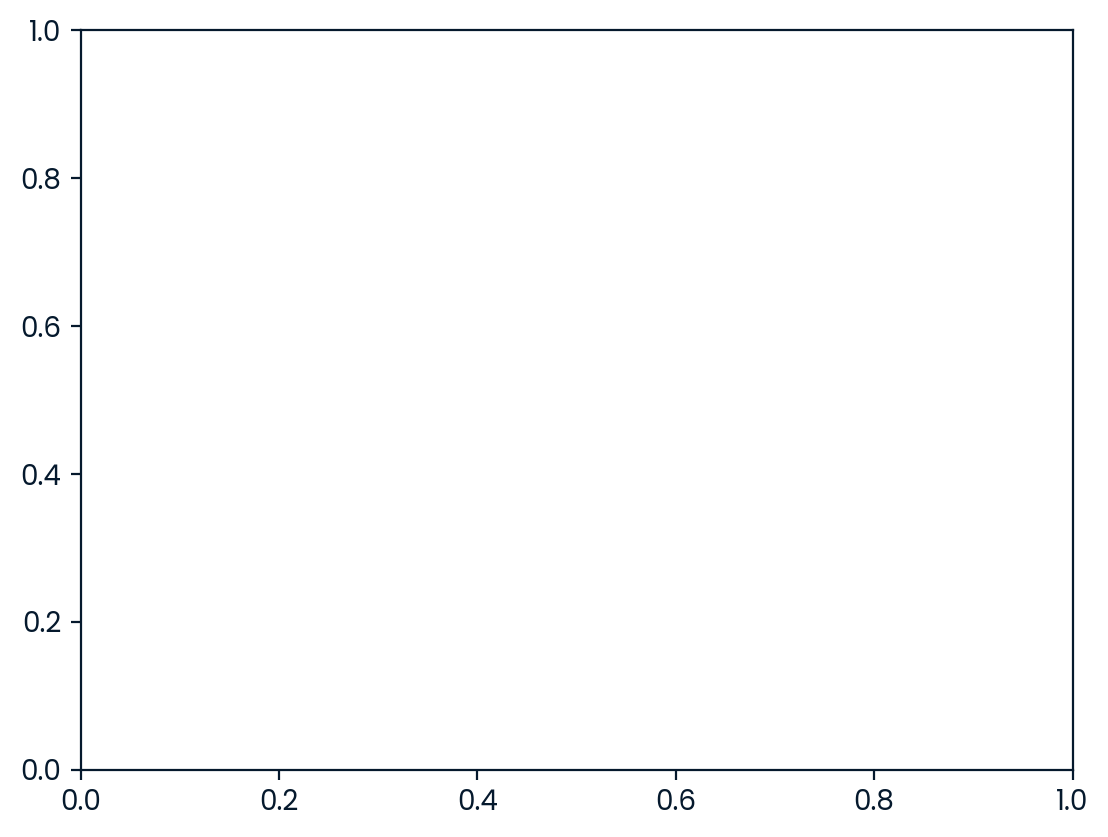

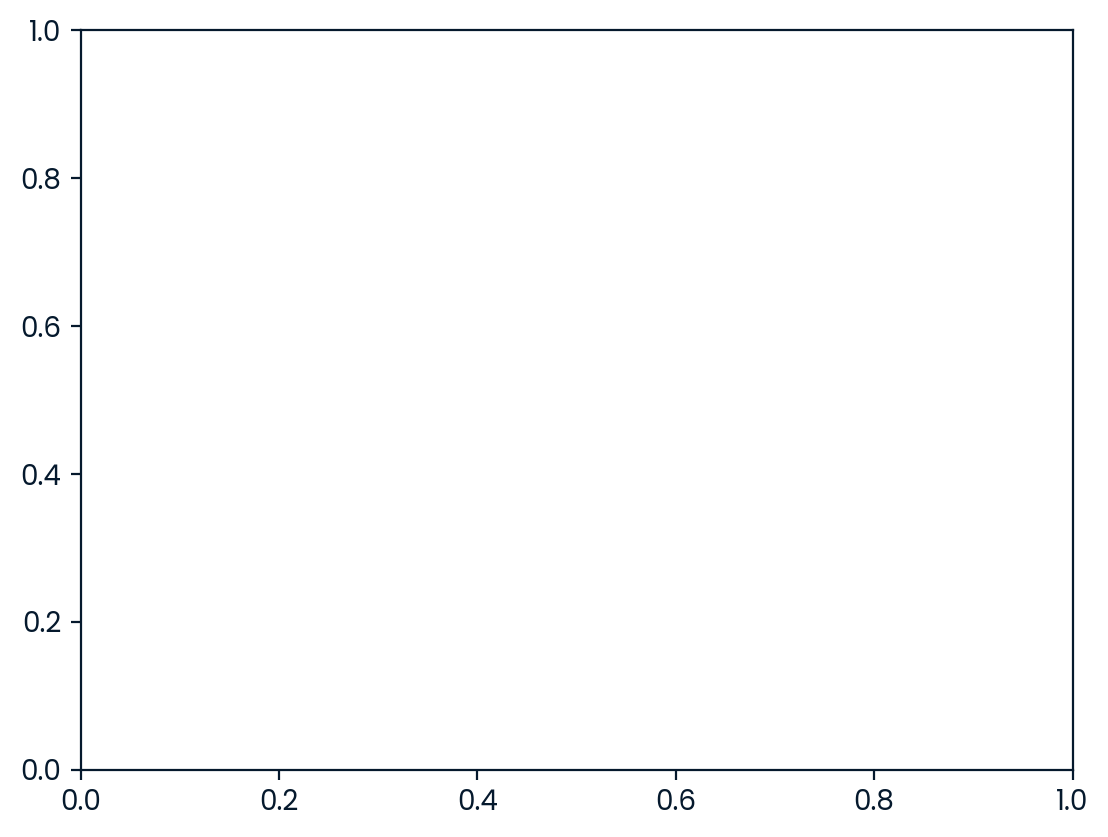

In [19]:
# Create your two charts below. Note, do not change the fig and ax variable names.

# Chart 1, a plot showing trading actions
fig, ax = plt.subplots()

# Chart 2, a plot of the balance_history over time
fig2, ax2 = plt.subplots()